Eight employees at a small company were asked to choose 3 movies that they would most enjoy watching for the upcoming company movie night. These choices are stored in the file `Employee_Movie_Choices.txt`.

A second file, `Employee_Relationships.txt`, has data on the relationships between different coworkers. 

The relationship score has value of `-100` (Enemies) to `+100` (Best Friends). A value of zero means the two employees haven't interacted or are indifferent.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt


# set of employees
employees = set(['Pablo',
                 'Lee',
                 'Georgia',
                 'Vincent',
                 'Andy',
                 'Frida',
                 'Joan',
                 'Claude'])
# set of movies
movies = set(['The Shawshank Redemption',
              'Forrest Gump',
              'The Matrix',
              'Anaconda',
              'The Social Network',
              'The Godfather',
              'Monty Python and the Holy Grail',
              'Snakes on a Plane',
              'Kung Fu Panda',
              'The Dark Knight',
              'Mean Girls'])

In [2]:
##########################################################################################################
# 1
# Using NetworkX, load in the bipartite graph from Employee_Movie_Choices.txt and return that graph.
# This function should return a networkx graph with 19 nodes and 24 edges
##########################################################################################################
def load_bipartite():
    G = pd.read_csv('Employee_Movie_Choices.txt', sep='\t')
    G = nx.from_pandas_edgelist(G, '#Employee', 'Movie')
    return G


#############################################################################################################
# 2
# Using the graph from the previous function load_bipartite, add nodes attributes named 'type' 
# where movies have the value 'movie' and employees have the value 'employee' and return that graph.
# This function should return a networkx graph with node attributes {'type': 'movie'} or {'type': 'employee'}
##########################################################################################################
def add_node_attr():
    G = load_bipartite()
    for node in G.nodes():
        if node in employees:
            G.add_node(node, type="employee")
        else:
            G.add_node(node, type="movie")
    return G


##########################################################################################################
# 3
# Find a weighted projection of the graph from previous function 
# which tells us how many movies different pairs of employees have in common.
# This function should return a weighted projected graph.
##########################################################################################################
def weighted_projection():
    G = add_node_attr() 
    P = bipartite.weighted_projected_graph(G, employees)
    return P



##########################################################################################################
# 4
# Find out if people that have a high relationship score also like the same types of movies.
# Find the Pearson correlation ( using DataFrame.corr() ) between 
# employee relationship scores and the number of movies they have in common. 
# If two employees have no movies in common it should be treated as a 0, not a missing value, 
# and should be included in the correlation calculation.
# This function should return a float.
##########################################################################################################
def pearson_correlation():        
    Rel = nx.read_edgelist('Employee_Relationships.txt', data=[('relationship_score', int)])
    Rel_df = pd.DataFrame(Rel.edges(data=True), columns=['From', 'To', 'relationship_score'])
    G = weighted_projection()
    G = pd.DataFrame(G.edges(data=True), columns=['From', 'To', 'movies_score'])
    G_reverse = G.copy()
    G_reverse.rename(columns={"From":"tmp_From", "To":"From"}, inplace=True)
    G_reverse.rename(columns={"tmp_From":"To"}, inplace=True)
    G_common = pd.concat([G, G_reverse])
    
    corr_df = pd.merge(G_common, Rel_df, on=['From', 'To'], how='right')
    corr_df['movies_score'] = corr_df['movies_score'].map(lambda x: x['weight'] if type(x)==dict else None)
    corr_df['relationship_score'] = corr_df['relationship_score'].map(lambda x: x['relationship_score'])
    corr_df['movies_score'].fillna(value=0, inplace=True)
    return corr_df, corr_df['movies_score'].corr(corr_df['relationship_score'])


##########################################################################################################

In [3]:
# load the bipartite graph from Employee_Movie_Choices.txt
# return a networkx graph with 19 nodes and 24 edges
df = pd.read_csv('Employee_Movie_Choices.txt', sep='\t')
df

,#Employee,Movie
0,Andy,Anaconda
1,Andy,Mean Girls
2,Andy,The Matrix
3,Claude,Anaconda
4,Claude,Monty Python and the Holy Grail
5,Claude,Snakes on a Plane
6,Frida,The Matrix
7,Frida,The Shawshank Redemption
8,Frida,The Social Network
9,Georgia,Anaconda


D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


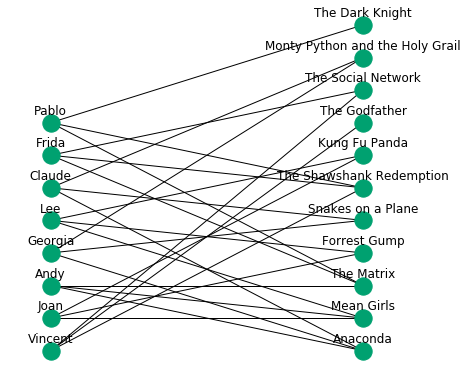

In [4]:
# build graph
G = nx.from_pandas_edgelist(df, '#Employee', 'Movie')

# get pos
X, Y = bipartite.sets(G)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) )
pos.update( (n, (2, i)) for i, n in enumerate(Y) )

# draw graph
graph = plt.figure(figsize=(5,5))
nx.draw(G, pos=pos, node_color='#00A170')

# draw label
for node_name in pos.keys():
    x = pos.get(node_name)[0]
    y = pos.get(node_name)[1] + 0.25
    plt.text(x,y,s=node_name, fontsize=12, horizontalalignment='center')

plt.show()

In [5]:
corr_df, corr = pearson_correlation()
corr_df

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,From,To,movies_score,relationship_score
0,Joan,Lee,3.0,70
1,Andy,Georgia,1.0,-10
2,Andy,Lee,1.0,-10
3,Andy,Claude,1.0,0
4,Andy,Frida,1.0,20
5,Andy,Pablo,1.0,-10
6,Frida,Pablo,2.0,50
7,Pablo,Vincent,1.0,-20
8,Frida,Vincent,2.0,60
9,Andy,Joan,1.0,30


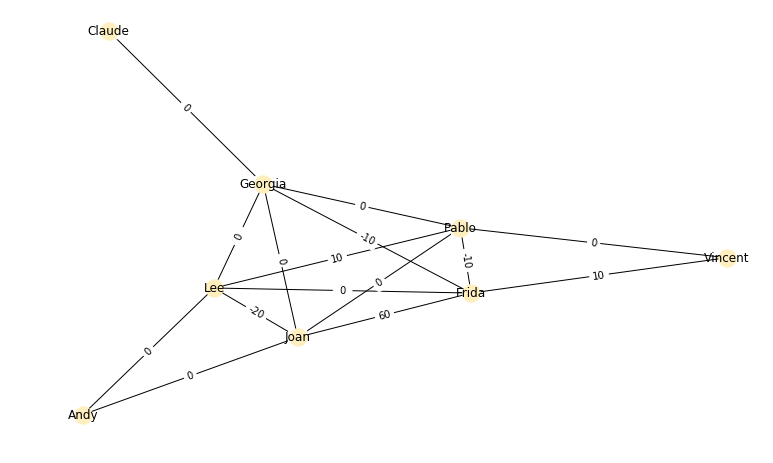

In [6]:
# get relationship information
Rel_G = nx.read_edgelist('Employee_Relationships.txt', data=[('relationship_score', int)])
Rel_df = pd.DataFrame(Rel_G.edges(data=True), columns=['From', 'To', 'relationship_score'])
relationship = {(f, t) for f in Rel_df['From'] for t in Rel_df['To']}

relationship_score = []
for score in Rel_df['relationship_score'].tolist():
    relationship_score.append(list(score.values())[0])
weight_dict = dict(zip(relationship, relationship_score))
rel_info = []
for k, v in weight_dict.items():
    tmp = [k,v]
    rel_info.append(tmp)

# build relationship graph
Relationship_G=nx.Graph()
for rel in rel_info:
    Relationship_G.add_edge(rel[0][0],rel[0][1], length=rel[1])
# Relationship_G.add_edges_from(list(weight_dict.keys()))

# get pos
pos=nx.spring_layout(Relationship_G)

# print graph
graph = plt.figure(figsize=(10,6))
nx.draw(Relationship_G, pos=pos, node_color='#FFEFBF', labels={node : node for node in Relationship_G.nodes()})

# print edge label
nx.draw_networkx_edge_labels(Relationship_G,pos,edge_labels=weight_dict,font_color='k')
plt.show()

In [7]:
print("The Pearson correlation between employee relationship scores and the number of movies they have in common is: ")
corr

The Pearson correlation between employee relationship scores and the number of movies they have in common is: 


0.7883962221733473